In [4]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["bpe", "whitespace"]
RUN_NAME = "tokenization"

INFOLDER = "out_tokenizer"
RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]
LIMIT = "full"

VOCAB = 50000
SEQ_LEN = 512


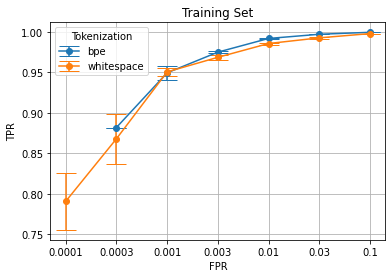

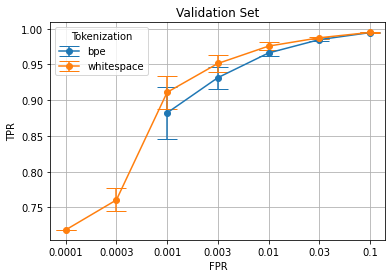

In [5]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [6]:
models = defaultdict(dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }

In [7]:
existing_pickle = os.path.join(INFOLDER, f"roc_metrics_val_{RUN_END_FILTER}.pkl")
if os.path.exists(existing_pickle):
    metrics_val = pickle.load(open(existing_pickle, "rb"))
else:
    metrics_val = defaultdict(list)
    model_files = defaultdict(list)
    for folder in run_folders:
        key = folder.split("_")[1]
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96,
                metrics_full=True
            )
            metrics_val[key].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
    pickle.dump(metrics_val, open(existing_pickle, "wb"))

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: bpe
[*] Running ROC for split: 0
Evaluating bpe_split_0 | Size: 5397313...


100%|██████████| 265/265 [00:09<00:00, 27.82it/s]


[*] Running ROC for split: 1
Evaluating bpe_split_1 | Size: 5397313...


100%|██████████| 265/265 [00:09<00:00, 27.54it/s]


[*] Running ROC for split: 2
Evaluating bpe_split_2 | Size: 5397313...


100%|██████████| 265/265 [00:09<00:00, 28.20it/s]


[*] In process: whitespace
[*] Running ROC for split: 0
Evaluating whitespace_split_0 | Size: 5397249...


100%|██████████| 265/265 [00:09<00:00, 29.25it/s]


[*] Running ROC for split: 1
Evaluating whitespace_split_1 | Size: 5397249...


100%|██████████| 265/265 [00:09<00:00, 29.35it/s]


[*] Running ROC for split: 2
Evaluating whitespace_split_2 | Size: 5397249...


100%|██████████| 265/265 [00:09<00:00, 29.16it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
bpe,0.267663,0.403259,0.858068,0.919520,0.965561,0.984782,0.994636,0.998639,0.997326,0.984649,0.985988,0.983330,0.979219
whitespace,0.526258,0.676983,0.892500,0.950719,0.974578,0.987231,0.994869,0.998756,0.997850,0.986614,0.985851,0.987408,0.981912


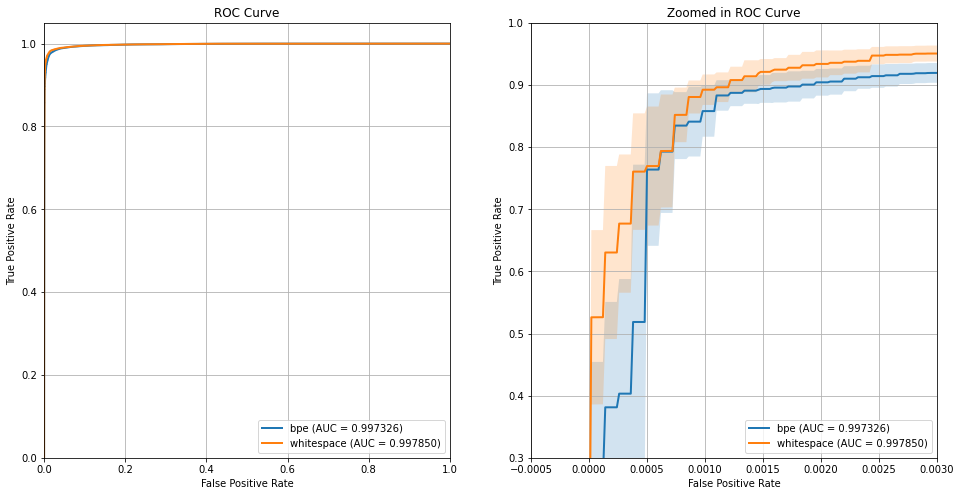

In [9]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [10]:
existing_pickle = os.path.join(INFOLDER, f"roc_metrics_test_{RUN_END_FILTER}.pkl")
if os.path.exists(existing_pickle):
    metrics_test = pickle.load(open(existing_pickle, "rb"))
else:
    metrics_test = defaultdict(list)
    model_files = defaultdict(list)
    for folder in run_folders:
        key = folder.split("_")[1]
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if key in x and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96,
                metrics_full=True
            )
            metrics_test[key].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
    pickle.dump(metrics_test, open(existing_pickle, "wb"))

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

[*] In process: bpe
[*] Running ROC for split: 0
Evaluating bpe_split_0 | Size: 5397313...


100%|██████████| 182/182 [00:05<00:00, 31.11it/s]


[*] Running ROC for split: 1
Evaluating bpe_split_1 | Size: 5397313...


100%|██████████| 182/182 [00:05<00:00, 31.26it/s]


[*] Running ROC for split: 2
Evaluating bpe_split_2 | Size: 5397313...


100%|██████████| 182/182 [00:06<00:00, 28.96it/s]


[*] In process: whitespace
[*] Running ROC for split: 0
Evaluating whitespace_split_0 | Size: 5397249...


100%|██████████| 182/182 [00:06<00:00, 29.62it/s]


[*] Running ROC for split: 1
Evaluating whitespace_split_1 | Size: 5397249...


100%|██████████| 182/182 [00:06<00:00, 29.18it/s]


[*] Running ROC for split: 2
Evaluating whitespace_split_2 | Size: 5397249...


100%|██████████| 182/182 [00:06<00:00, 28.62it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
bpe,0.249778,0.373250,0.575526,0.711262,0.789606,0.856181,0.908781,0.955050,0.966264,0.913821,0.875784,0.955777,0.910821
whitespace,0.308731,0.372931,0.552732,0.701797,0.795739,0.862101,0.913715,0.953632,0.966298,0.906365,0.853167,0.967421,0.904904


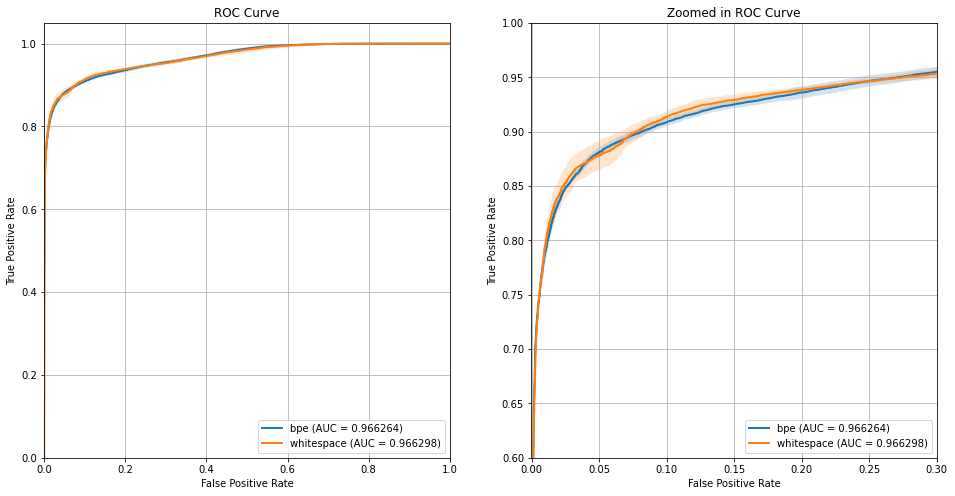

In [13]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

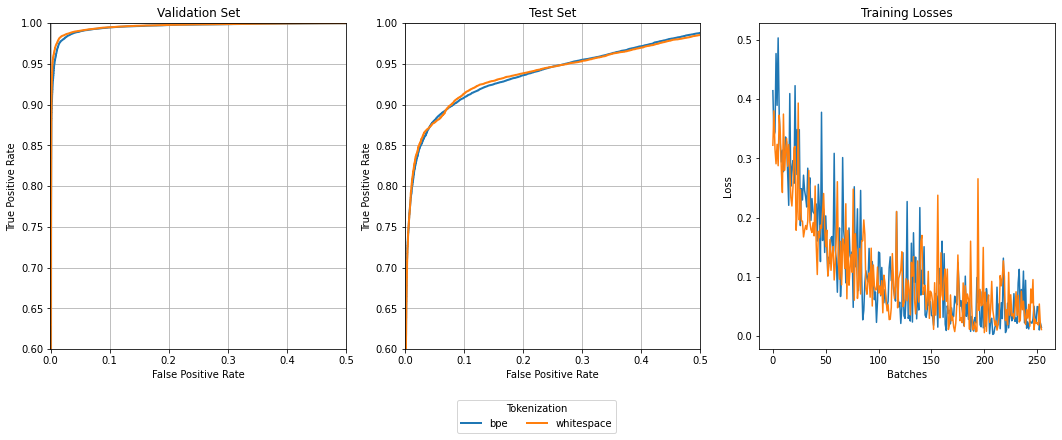

In [16]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 100
n = 10
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')